In [1]:
import os
import json
from PIL import Image

# Step 1: Clone the dataset repository
def clone_repo(repo_url, target_dir):
    if not os.path.exists(target_dir):
        print(f"Cloning repository from {repo_url}...")
        # Use shell command directly in Colab
        !git clone {repo_url} {target_dir}
    else:
        print(f"Repository already cloned at {target_dir}")

# Step 2: Convert the dataset to COCO format
def convert_dataset_to_coco(root_dir, output_file):
    coco_data = {
        "images": [],
        "annotations": [],
        "categories": [
            {"id": 1, "name": "fractured", "supercategory": "fracture"},
            {"id": 2, "name": "not fractured", "supercategory": "not fractured"}
        ]
    }

    annotation_id = 1
    image_id = 1

    # Iterate through each split (train, val, test)
    for split in ["train", "val", "test"]:
        split_dir = os.path.join(root_dir, split)
        for class_name in ["fractured", "not fractured"]:
            class_dir = os.path.join(split_dir, class_name)

            if not os.path.exists(class_dir):
                print(f"Directory {class_dir} does not exist, skipping...")
                continue

            for img_file in os.listdir(class_dir):
                if img_file.endswith('.jpg') or img_file.endswith('.jpeg') or img_file.endswith('.png'):
                    img_path = os.path.join(class_dir, img_file)
                    try:
                        img = Image.open(img_path)
                        width, height = img.size

                        coco_data["images"].append({
                            "id": image_id,
                            "file_name": os.path.join(split, class_name, img_file),
                            "width": width,
                            "height": height
                        })

                        # Creating dummy bounding box (assuming full image as bounding box)
                        bbox = [0, 0, width, height]  # Dummy placeholder (no actual bounding box)

                        coco_data["annotations"].append({
                            "id": annotation_id,
                            "image_id": image_id,
                            "category_id": 1 if class_name == "fractured" else 2,  # 1 for fractured, 2 for not fractured
                            "bbox": bbox,
                            "area": width * height,  # Dummy area
                            "iscrowd": 0
                        })

                        image_id += 1
                        annotation_id += 1

                    except (OSError, Image.DecompressionBombError):
                        print(f"Skipping corrupted image {img_path}")
                        continue

    # Write the COCO data to a JSON file
    with open(output_file, 'w') as json_file:
        json.dump(coco_data, json_file)

    print(f"COCO dataset has been saved to {output_file}")

# Step 3: Main function to run the entire pipeline
def main():
    repo_url = "https://github.com/naveenkumar12624/New_Bone_data.git"
    target_dir = "/content/New_Bone_data"
    root_directory = os.path.join(target_dir, "Bone_Fracture_Binary_Classification")
    output_file = '/content/Bone_Fracture_Coco.json'

    # Step 1: Clone the repository
    clone_repo(repo_url, target_dir)

    # Step 2: Convert the dataset to COCO format
    convert_dataset_to_coco(root_directory, output_file)

# Run the main function
main()


Cloning repository from https://github.com/naveenkumar12624/New_Bone_data.git...
Cloning into '/content/New_Bone_data'...
remote: Enumerating objects: 3901, done.
remote: Total 3901 (delta 0), reused 0 (delta 0), pack-reused 3901 (from 1)
Receiving objects: 100% (3901/3901), 161.08 MiB | 23.84 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (10582/10582), done.
COCO dataset has been saved to /content/Bone_Fracture_Coco.json


In [5]:
import os
import json
from PIL import Image, ImageFile
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

class FractureDataset(Dataset):
    def __init__(self, annotations_file, root_dir, transform=None):
        with open(annotations_file, 'r') as f:
            self.coco_data = json.load(f)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.coco_data["images"])

    def __getitem__(self, idx):
        img_info = self.coco_data["images"][idx]
        img_path = os.path.join(self.root_dir, img_info["file_name"])

        # Try opening the image and skip if corrupted or truncated
        try:
            with Image.open(img_path) as img:
                img = img.convert("RGB")  # Ensure the image is in RGB format
        except (OSError, Image.DecompressionBombError, SyntaxError) as e:
            print(f"Warning: Skipping corrupted or truncated image at {img_path}. Error: {e}")
            return None  # Skip the image and return None

        annotation = next(ann for ann in self.coco_data["annotations"] if ann["image_id"] == img_info["id"])
        label = annotation["category_id"] - 1  # Labels: 0 for fractured, 1 for not fractured

        if self.transform:
            img = self.transform(img)

        return img, label



In [7]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset and create train/validation splits
dataset = FractureDataset(annotations_file='/content/Bone_Fracture_Coco.json',
                          root_dir='/content/New_Bone_data/Bone_Fracture_Binary_Classification',
                          transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [8]:
# Custom collate function to handle None values (corrupted images)
def collate_fn(batch):
    # Filter out any None values (corrupted images)
    batch = [item for item in batch if item is not None]
    return torch.utils.data.dataloader.default_collate(batch)

# Update DataLoader with collate_fn
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [9]:
import torch.nn as nn
from torchvision import models

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet model and adjust final layer for binary classification
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Output layer for 2 classes
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s]



# Define training and validation loop

In [10]:
import torch.optim as optim

# Set loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define training and validation loop
def train_validate_model(num_epochs):
    train_acc, val_acc = [], []
    train_loss, val_loss = [], []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        correct, total, running_loss = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

        train_acc.append(correct / total)
        train_loss.append(running_loss / len(train_loader))

        # Validation Phase
        model.eval()
        correct, total, running_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                running_loss += loss.item()

        val_acc.append(correct / total)
        val_loss.append(running_loss / len(val_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

    return train_acc, val_acc, train_loss, val_loss


# Set number of epochs

In [11]:
# Set number of epochs
num_epochs = 20
train_acc, val_acc, train_loss, val_loss = train_validate_model(num_epochs)


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/20], Train Acc: 0.9217, Val Acc: 0.8692
Epoch [2/20], Train Acc: 0.9739, Val Acc: 0.9797
Epoch [3/20], Train Acc: 0.9759, Val Acc: 0.9783
Epoch [4/20], Train Acc: 0.9872, Val Acc: 0.9603
Epoch [5/20], Train Acc: 0.9846, Val Acc: 0.9854
Epoch [6/20], Train Acc: 0.9940, Val Acc: 0.9948
Epoch [7/20], Train Acc: 0.9922, Val Acc: 0.9924
Epoch [8/20], Train Acc: 0.9845, Val Acc: 0.9934
Epoch [9/20], Train Acc: 0.9954, Val Acc: 0.9787
Epoch [10/20], Train Acc: 0.9920, Val Acc: 0.9953
Epoch [11/20], Train Acc: 0.9947, Val Acc: 0.9976
Epoch [12/20], Train Acc: 0.9928, Val Acc: 0.9565
Epoch [13/20], Train Acc: 0.9944, Val Acc: 0.9972
Epoch [14/20], Train Acc: 0.9949, Val Acc: 0.9877
Epoch [15/20], Train Acc: 0.9969, Val Acc: 0.9976
Epoch [16/20], Train Acc: 0.9994, Val Acc: 0.9972
Epoch [17/20], Train Acc: 0.9992, Val Acc: 0.9953
Epoch [18/20], Train Acc: 0.9921, Val Acc: 0.9806
Epoch [19/20], Train Acc: 0.9940, Val Acc: 0.9872
Epoch [20/20], Train Acc: 0.9994, Val Acc: 0.9976


# Plot training and validation accuracy and loss

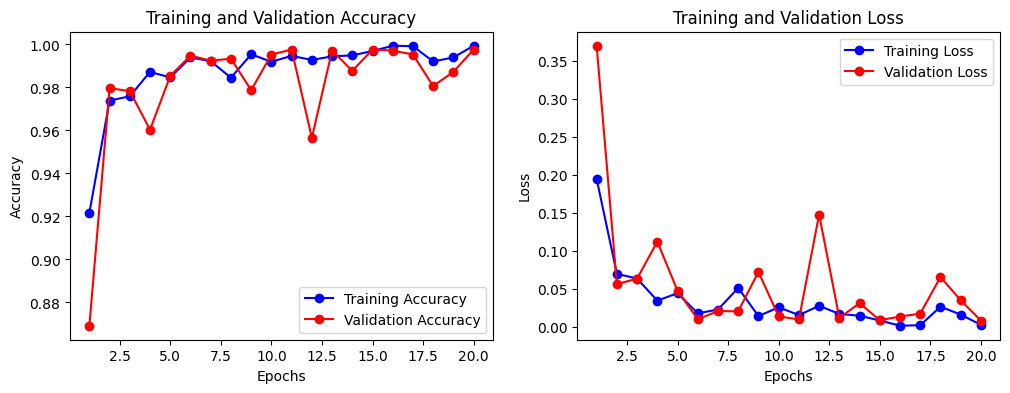

In [12]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy and loss
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()



In [13]:
import torch
import torch.nn as nn
from torchvision import models

# Check if 'model' is a model instance
model = models.resnet18(pretrained=True)  # Make sure to initialize a model
model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification output
model = model.to(device)  # Move to GPU if available

# Saving the model's state_dict
torch.save(model.state_dict(), 'bone_fracture_model.pth')


# Load the saved model weights into the model

In [14]:
# Initialize the model (must be the same architecture)
model = models.resnet18(pretrained=False)  # Set pretrained=False since we are loading custom weights
model.fc = nn.Linear(model.fc.in_features, 2)  # Ensure the final layer matches the trained one

# Load the saved model weights into the model
model.load_state_dict(torch.load('bone_fracture_model.pth'))

# Move the model to the appropriate device (GPU or CPU)
model = model.to(device)

# Set the model to evaluation mode
model.eval()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-14-2cdd298b8fce>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommen

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Define the necessary transformations (resize, normalize, etc.)

In [17]:
# from PIL import Image
# import torchvision.transforms as transforms

# def predict_image(image_path):
#     # Define the necessary transformations (resize, normalize, etc.)
#     transform = transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])

#     # Open and transform the image
#     image = Image.open(image_path).convert("RGB")
#     image = transform(image).unsqueeze(0)  # Add batch dimension

#     # Move image to the same device as the model
#     image = image.to(device)

#     # Make prediction
#     with torch.no_grad():
#         outputs = model(image)
#         _, predicted = torch.max(outputs, 1)
#         return "Fractured" if predicted.item() == 0 else "Not Fractured"

# # Example usage
# # image_path1 = '/content/Healthy_Bone_Dowloaded.jpg'
# # image_path = '/content/FracturedTestImage.jpeg'
# prediction = predict_image(image_path)
# print(f"The image is: {prediction}")


# Function to make predictions and mark fractures

In [18]:
import os
import random
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn

# Check for available device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model (ensure it's already loaded and in eval mode)
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification
model.load_state_dict(torch.load('bone_fracture_model.pth', map_location=device))  # Load the model on the correct device
model = model.to(device)  # Move the model to the device (GPU or CPU)
model.eval()

# Define transformations (same as during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

# Function to make predictions and mark fractures
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    original_image = image.copy()  # Keep the original image for visualization

    # Apply transformations
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move image to the same device as the model
    image = image.to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    # Get the label (0 = fractured, 1 = not fractured)
    label = "Fractured" if predicted.item() == 0 else "Not Fractured"

    # If fractured, mark the fracture part with a green box
    if label == "Fractured":
        # Here, we're just simulating a bounding box (you can modify this with actual bounding box data)
        draw = ImageDraw.Draw(original_image)
        width, height = original_image.size
        # Draw a green bounding box (dummy coordinates as an example)
        bbox = (50, 50, width - 50, height - 50)  # Coordinates for the box
        draw.rectangle(bbox, outline="green", width=5)

    return original_image, label


<ipython-input-18-63b1192ea390>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('bone_fracture_model.pth', map_location=device))  # Load t

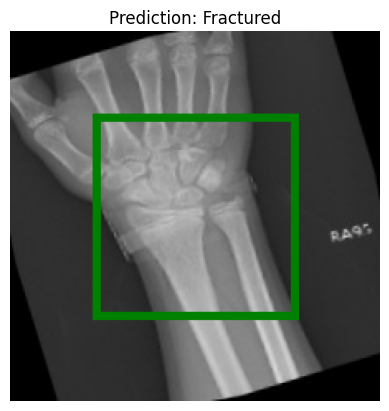

Prediction for the image: Fractured


In [19]:

# Randomly choose an image from the validation set
val_dir = "/content/New_Bone_data/Bone_Fracture_Binary_Classification/val"
folders = ["fractured", "not fractured"]
folder_choice = random.choice(folders)
image_choice = random.choice(os.listdir(os.path.join(val_dir, folder_choice)))
image_path = os.path.join(val_dir, folder_choice, image_choice)

# Get the prediction and display the result
image, label = predict_image(image_path)

# Display the image with prediction
plt.imshow(image)
plt.title(f"Prediction: {label}")
plt.axis('off')  # Turn off axis labels
plt.show()

print(f"Prediction for the image: {label}")


# Function to calculate predictions and true labels

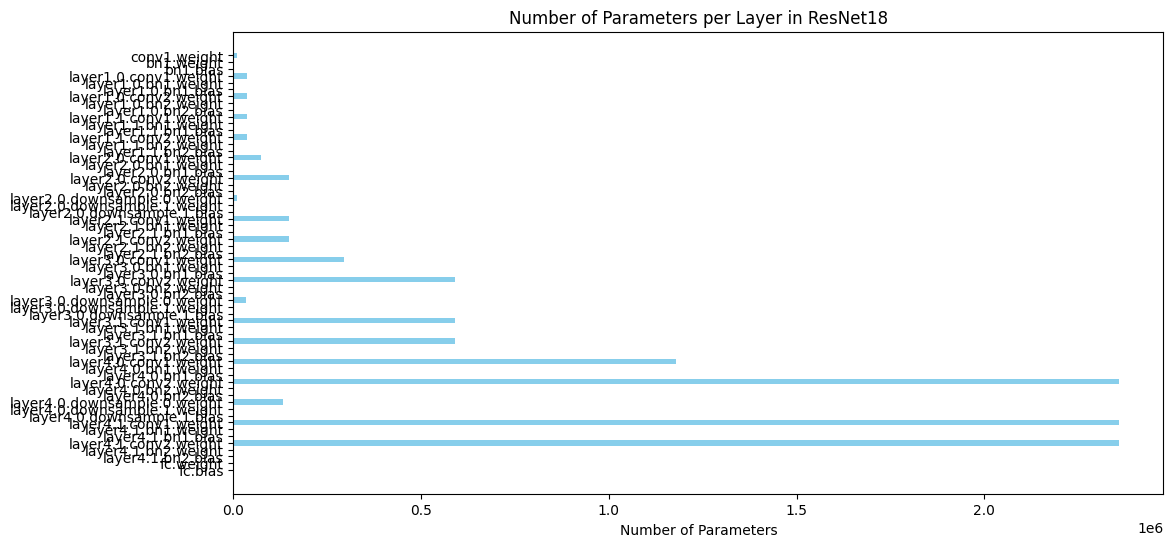

In [28]:
# Visualization of Parameters per Layer
layer_names = []
num_params = []
for name, param in model.named_parameters():
    if param.requires_grad:
        layer_names.append(name)
        num_params.append(param.numel())

# Plotting Number of Parameters per Layer
plt.figure(figsize=(12, 6))
plt.barh(layer_names,num_params, color='skyblue')
plt.xlabel("Number of Parameters")
plt.title("Number of Parameters per Layer in ResNet18")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()